Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2978
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3576

Total number of variables............................:      796
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

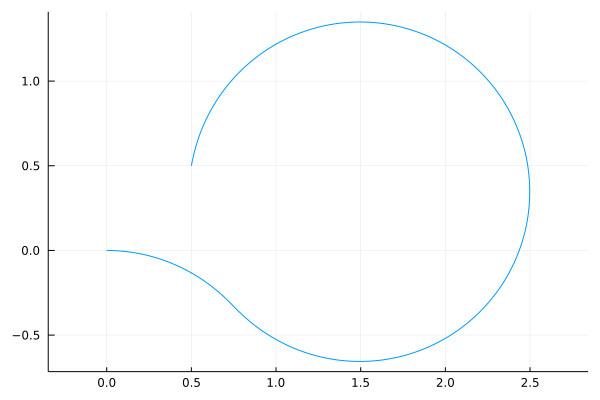

In [2]:
using JuMP
import Ipopt
import Plots

# Create JuMP model, using Ipopt as the solver
user_options = (
    # "mu_strategy" => "monotone",
    # "linear_solver" => "ma27",
)
dubins = Model(optimizer_with_attributes(Ipopt.Optimizer,user_options...))
#set_silent(dubins)

# Constants
vm = 1.0
um = 1.0        # Maximum thrust

x_f = 0.5
y_f = 0.5

n = 200    # Time steps
tmin = (2*pi*1)/vm
tmax = 100
# Decision variables

@variables(dubins, begin
    (tmin)/n <= Δt <= (tmax)/n  # Time step
    ## State variables
    x[1:n]            # Velocity
    y[1:n]            # Height
    th[1:n]           # Height
    ## Control variables
    -um ≤ u[1:n] ≤ um    # Thrust
end)

# Objective
@objective(dubins, Min, Δt)

## Initial conditions
fix(x[1], 0; force = true)
fix(y[1], 0; force = true)
fix(th[1], 0; force = true)

## Final conditions
fix(x[n], x_f; force = true)
fix(y[n], y_f; force = true)
# fix(th[n], pi/2; force = true)


## Dynamics

for j in 2:n
    @NLconstraint(dubins, x[j] == x[j - 1] + Δt *0.5* vm*(cos(th[j - 1])+cos(th[j])))
    ## Trapezoidal integration
    @NLconstraint(dubins, y[j] == y[j - 1] + Δt *0.5* vm*(sin(th[j - 1])+sin(th[j])))
    ## Trapezoidal integration
    @NLconstraint(dubins, th[j] == th[j - 1] + 0.5*Δt * (u[j]+u[j-1]))
    ## Trapezoidal integration
end

# Solve for the control and state
println("Solving...")
optimize!(dubins)
solution_summary(dubins)

# ## Display results

println("Min time: ", objective_value(dubins)*n)


Plots.plot(value.(x), value.(y), legend = false, aspect_ratio=:equal)

In [135]:
value.(u)

200-element Vector{Float64}:
 -0.9999659217951351
 -0.999982639595457
 -0.9999819483435473
 -0.9999812000888186
 -0.9999803881309629
 -0.9999795046880648
 -0.9999785406708488
 -0.9999774853980123
 -0.999976326233908
 -0.9999750481226947
 -0.9999736329827387
 -0.9999720589097982
 -0.9999702991146664
  ⋮
  0.999949021030738
  0.9999433904468062
  0.9999364800465352
  0.9999278086470388
  0.9999166200182272
  0.9999016536810865
  0.9998806406811989
  0.9998490430833445
  0.9997962727278494
  0.9996905681161052
  0.9993731631674134
  0.9974614919348601

In [137]:
using CSV, DataFrames
x_fin = ones(n)*x_f
y_fin = ones(n)*y_f
matrix = hcat(x_fin,y_fin,value.(x),value.(y),value.(th),value.(u))
CSV.write("D:\\Julia\\data\\dubinsInCirc.csv", DataFrame(matrix, :auto),
                         header = false, append = true)

"D:\\Julia\\data\\dubinsInCirc.csv"